In [1]:
"""This script generates the combined statistics of all the masks."""

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.style.use("fivethirtyeight")

In [2]:
#read in all the visual inspection xlsx files
mask_df_dict = {} #dictionary to store all the xlsx files as dataframes

import glob, os
for file in glob.glob("../results/Max_z_n_width/*.xlsx"):
    
    #get the masknumber for the bluer masks
    tmp = file.split("\\")[1]
    tmp = tmp.split("_")[0]
    tmp_bluemask = tmp.split("+")[0]
    
    #store read in files as pandas dataframe in dict
    mask_df_dict[tmp_bluemask] = pd.read_excel(file, header = 0)

In [6]:
def datareader(maskname, dir_name = "../data/npz_files/"):
	"""Reads mask data for use by the other functions in this module
	Parameters
	----------
	maskname: name of the mask + '-' + grating number
	"""
	
	fname = maskname + '-' + 'spec1d.npz'
	data = np.load(dir_name + fname)
	
	return data

def bit_from_header(header):
	name = header["SLITOBJ"]
	if name == "stars":
		name = 2**1
	elif name == "gal":
		name = 2**2
	return int(name)

def bit_adder(key):
    data_b = datareader(key)
    
    #Store bit values in the dataframes
    tmpbit = []
    for i in range(1,len(mask_df_dict[key])+1):
        bit = bit_from_header(data_b['headers'][i])
        tmpbit.append(bit)
    mask_df_dict[key]['bitval'] = tmpbit

In [4]:
#preprocess_bino

#[O II] doublet
lambda27 = 3727.092
lambda29 = 3729.875
separation = (lambda29 - lambda27)/2 #separation between the emission lines
lambda0 = lambda27 + separation #Midpoint of the gaussian emission lines in restframe

#velocity dispersion array
sigma_v = np.arange(0, 201, 5)

#Other lines; values from SDSS
OII = lambda0
hB0 = 4862.68
OIII1 = 4960.295
OIII2 = 5008.240
ha = 6564.61   

#plotting variables
alpha = 0.7
vmin = -0.5; vmax = 1 #for imshow
fontsize = 25
font = 'serif'

#functional parameters for [O II] modelling
relative_strength = 0.7 #relative strength ratio between left line and right line
fudge_factor = 1. #multiplicative factor over slit width

#for mask_summary.py histogram plot
histtype = 'step'
lw = 3 #line width of histogram
#range of histogram for same binning
hist_left = 0.
hist_right = 1.6
bins = 16

In [5]:
##--ALL THE DICTIONARIES USED IN THIS CODE--##

#Dictionary in which subdataframes by confidence level only are stored
confidence_df_dict = {}

#Dictionary consisting of algorithm name and bit values 
bit_dict = {'fdr': 2**3, 'ndm': 2**4 + 2**6 + 2**7, 
 'rf': 2**8 + 2**9 + 2**10}

#Dictionary consisting of 9 dataframes by confidence class
#and algorithm class
conf_alg_df_dict = {}

#Dictionary consisting of confidence level naming convention;
#the keys are designed to iterate over for plotting purposes
#such as the histogram
conf_name_dict = {1:'3', 2:'3+2', 3:'3+2+1'}

#Dictionary for storing all the statistics
statistics_dict = {}
##--END OF LIST OF DICTIONARIES--##

In [7]:
for key in mask_df_dict:
    bit_adder(key)

In [13]:
mask_df_dict['1186'].head()

,Slit Num,z_b,vel_b,Confidence_b,Notes_b,z_r,vel_r,Confidence_r,Notes_r,bitval
0,1,1.004494,85.0,3.0,NaN,NaN,NaN,NaN,NaN,8
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80
2,3,0.840494,60.0,3.0,NaN,0.840214,130.0,3.0,w*hb,216
3,4,NaN,NaN,NaN,NaN,1.455603,65.0,1.0,NaN,2008
4,5,NaN,NaN,NaN,NaN,1.239403,90.0,1.0,NaN,984


In [20]:
frames = []
for key in mask_df_dict:
    frames.append(mask_df_dict[key])
master_df = pd.concat(frames)

C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [22]:
master_df.head()

,Confidence_b,Confidence_r,Dec_b,Dec_r,Notes_b,Notes_r,RA_b,RA_r,Slit Num,amp_b,amp_r,bitval,vel_b,vel_r,z_b,z_r
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,8,85.0,NaN,1.004494,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,80,NaN,NaN,NaN,NaN
2,3.0,3,NaN,NaN,NaN,w*hb,NaN,NaN,3,NaN,NaN,216,60.0,130.0,0.840494,0.840214
3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,2008,NaN,65.0,NaN,1.455603
4,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,984,NaN,90.0,NaN,1.239403


In [23]:
#Create subdataframes based on confidence levels:
confidence_df_dict['df_conf3'] = master_df.loc[((master_df['Confidence_b'] == 3) | (master_df['Confidence_r'] == 3))] #Confidence 3
confidence_df_dict['df_conf32'] = master_df.loc[((master_df['Confidence_b'] == 3) | (master_df['Confidence_r'] == 3)) | \
 ((master_df['Confidence_b'] == 2) | (master_df['Confidence_r'] == 2))] #Confidence 3+2
confidence_df_dict['df_conf321'] = master_df.loc[((master_df['Confidence_b'] == 3) | (master_df['Confidence_r'] == 3)) | \
 ((master_df['Confidence_b'] == 2) | (master_df['Confidence_r'] == 2)) | \
 ((master_df['Confidence_b'] == 1) | (master_df['Confidence_r'] == 1))] #Confidence 3+2+1

In [24]:
#calculate mean z to get the final z that will be used for statistics
for key in confidence_df_dict:
    confidence_df_dict[key]['z_final'] = confidence_df_dict[key][['z_b', 'z_r']].mean(axis = 1)

C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
#Split the 3 confidence levels into 3 further levels on the basis of algorithms
for bitkey in bit_dict:
    for dfkey in confidence_df_dict:
        conf_alg_df_dict[dfkey + '_' + bitkey] = \
        confidence_df_dict[dfkey][np.bitwise_and(confidence_df_dict[dfkey]['bitval'], \
                                                 bit_dict[bitkey]) > 0]

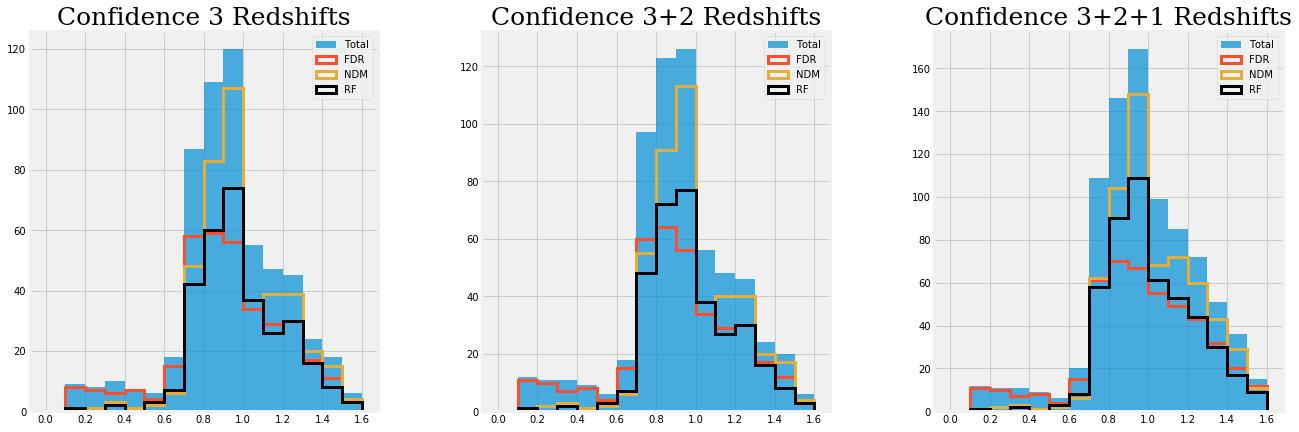

In [27]:
##--HISTOGRAM PLOTTING--##										 
#Regular histogram
fig = plt.figure(1, figsize=(20,7))
gridspec.GridSpec(1,3)

for i in range(1,4):
    ax = plt.subplot2grid((1,3), (0, i-1))
    confidence_df_dict['df_conf' + \
                       "".join(conf_name_dict[i].split("+"))].hist('z_final', bins = bins, \
                                            ax = ax, alpha = alpha, \
                                            label = "Total", \
                                            range = (hist_left, hist_right))
    
    #"".join([str1, str2]) concatenates all the strings into str1str2
    for bitkey in bit_dict:
        dfname = 'df_conf' + "".join(conf_name_dict[i].split("+")) + '_' + bitkey
        
        if(bitkey == 'rf'):
            conf_alg_df_dict[dfname].hist('z_final', bins = bins, histtype = histtype, \
                                         linewidth = lw, ax = ax, \
                                          label = bitkey.upper(), \
                                          color = 'k', range = (hist_left, hist_right))
        else:
            conf_alg_df_dict[dfname].hist('z_final', bins = bins, histtype = histtype, \
                                         linewidth = lw, ax = ax, \
                                          label = bitkey.upper(), \
                                          range = (hist_left, hist_right))
        ax.set_title('Confidence ' + conf_name_dict[i] + ' Redshifts', \
                     family = font, fontsize = fontsize)
        ax.legend(loc = 'best')
        
plt.savefig("../results/summary_statistics/Overall_hist.png", dpi = 250, bbox_inches = 'tight')

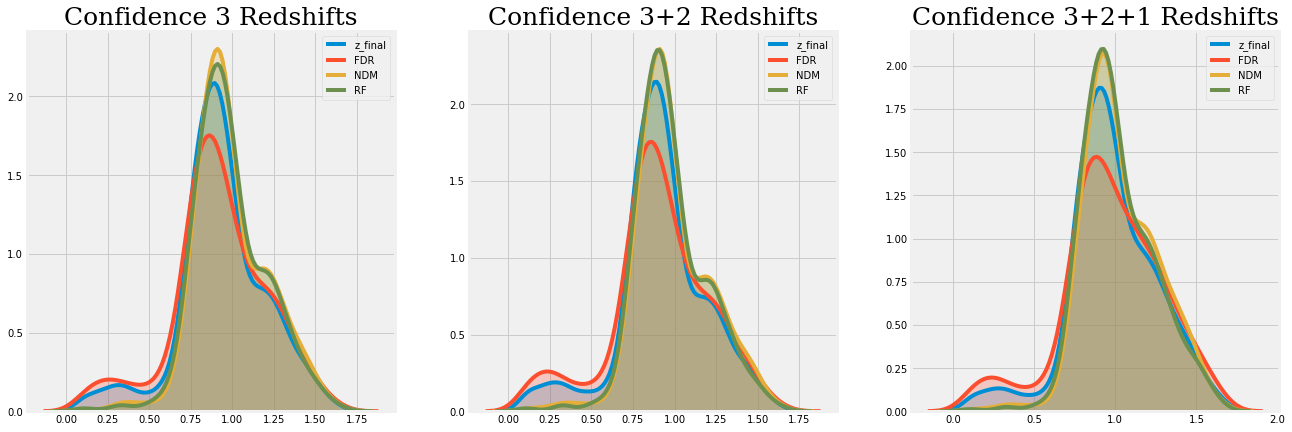

In [28]:
import seaborn as sns
##--KDE PLOTTING--##										 
fig = plt.figure(1, figsize=(20,7))
gridspec.GridSpec(1,3)

for i in range(1,4):
    ax = plt.subplot2grid((1,3), (0, i-1))
    sns.kdeplot(confidence_df_dict['df_conf' + "".join(conf_name_dict[i].split("+"))]['z_final'], \
                ax=ax, shade=True)
    
    #"".join([str1, str2]) concatenates all the strings into str1str2
    for bitkey in bit_dict:
        dfname = 'df_conf' + "".join(conf_name_dict[i].split("+")) + '_' + bitkey
        
        if(bitkey == 'rf'):
            sns.kdeplot(conf_alg_df_dict[dfname]['z_final'], ax = ax, shade = True,\
                       label = bitkey.upper())
        
        else:
            sns.kdeplot(conf_alg_df_dict[dfname]['z_final'], ax = ax, shade = True, \
                       label = bitkey.upper())
        ax.set_title('Confidence ' + conf_name_dict[i] + ' Redshifts', \
                     family = font, fontsize = fontsize)
        ax.legend(loc = 'best')

In [33]:
##--SUMMARY STATISTICS TABLE--##
#calculates summary statistics based on dataframe and algorithm
def summary_stats(dataframe):
	"""Returns summary statistics based on given dataframe
	Parameters
	----------
	dataframe: confidence+algorithm dataframe for which stats
	is required; from conf_alg_df_dict
	"""
	
	#Percentage of objects proposed by this confidence+algo in this mask
	nobj = len(conf_alg_df_dict[dataframe])
	percentage_in_mask = nobj/len(master_df)*100 #df is the master table
	
	#total number of objects in this algorithm in this mask
	#dataframe.split("_")[-1] finds whether last chunk in dataframe
	#name is fdr, ndm or rf. Then bit_dict calls the bit value
	nobjtot = len(master_df[np.bitwise_and(master_df['bitval'], bit_dict[dataframe.split("_")[-1]]) > 0.])
	
	#total success rate in alg
	totalz_success_rate_in_alg = nobj / nobjtot*100
	
	#highz = [1.1 +]; medz = [0.6, 1.1]
	highz_success_rate_in_alg = \
	len(conf_alg_df_dict[dataframe].loc[conf_alg_df_dict[dataframe]['z_final'] > 1.1]) / \
																		nobjtot*100
	medz_success_rate_in_alg = \
	len(conf_alg_df_dict[dataframe].loc[(conf_alg_df_dict[dataframe]['z_final'] > 0.6) \
						& (conf_alg_df_dict[dataframe]['z_final'] < 1.1)])/nobjtot*100
	
	lowz_success_rate_in_alg = \
	len(conf_alg_df_dict[dataframe].loc[(conf_alg_df_dict[dataframe]['z_final'] < 0.6) \
						& (conf_alg_df_dict[dataframe]['z_final'] < 1.1)])/nobjtot*100
						
	#round all rates to 2 decimal places
	percentage_in_mask = np.round(percentage_in_mask, 2)
	totalz_success_rate_in_alg = np.round(totalz_success_rate_in_alg, 2)
	highz_success_rate_in_alg = np.round(highz_success_rate_in_alg, 2)
	medz_success_rate_in_alg = np.round(medz_success_rate_in_alg, 2)
	lowz_success_rate_in_alg = np.round(lowz_success_rate_in_alg, 2)
	
	return nobj, percentage_in_mask, \
	 totalz_success_rate_in_alg, lowz_success_rate_in_alg, medz_success_rate_in_alg, \
	 highz_success_rate_in_alg

def noZ_stats(dataframe):
	"""Returns summary statistics of noZ class
	based on given dataframe.
	Parameters
	----------
	dataframe: confidence+algorithm dataframe for which stats
	is required; from conf_alg_df_dict
	"""
	
	#Total no. of objects in mask
	nobjtot_in_mask = len(master_df)
	
	#Total no. of objects in mask for a given algorithm
	nobjtot_in_alg = len(master_df[np.bitwise_and(master_df['bitval'], bit_dict[dataframe.split("_")[-1]]) > 0])
	
	#Total no. of noZ objects in given algorithm
	noZobj_in_alg = nobjtot_in_alg - len(conf_alg_df_dict[dataframe]) #dataframe must be of type 321
	noZ_percentage_in_alg = noZobj_in_alg/nobjtot_in_alg*100 #percentage in alg
	noZ_percentage_in_mask = noZobj_in_alg/nobjtot_in_mask*100 #percentage in mask
	
	return noZobj_in_alg, \
	 np.round(noZ_percentage_in_mask,2), np.round(noZ_percentage_in_alg,2), '-', '-', '-'

#add 'NoZ' as the 4th conf_name_dict val
conf_name_dict[4] = 'noZ'

#Calculate all the necessary statistics and store in statistics_dict
for bitkey in bit_dict:
	for i in range(1,5):
		#print(conf_name_dict[i])
		if(conf_name_dict[i] == 'noZ'):
			key = 'df_conf321_' + bitkey
			statistics_dictkey = bitkey + '_' + conf_name_dict[i]
			statistics_dict[statistics_dictkey] = bitkey.upper(), conf_name_dict[i], noZ_stats(key)
			
		else:
			key = 'df_conf' + "".join(conf_name_dict[i].split("+")) + '_' + bitkey
			statistics_dictkey = bitkey + '_' + conf_name_dict[i]
			statistics_dict[statistics_dictkey] = bitkey.upper(), conf_name_dict[i], summary_stats(key)
			
#Print out the summary table
print('{:5s} {:8s} {:6s} {:12s} {:12s} {:17s} {:17s} {:10s}'.format('Alg', \
															'Conf', \
															'Nobj', '% in mask',\
															'%in alg', \
											'% [0,0.6] alg', '% [0.6,1.1] alg',\
															 '% >1.1 alg'))

print("-----------------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------------")
for k, v in statistics_dict.items():
	alg, conf, stats = v
	nobj, permask, peralg, perlow, permed, perhigh = stats
	
	print('{:5s} {:8s} {:6s} {:10s} {:14s} {:16s} {:17s} {:10s}'.format(alg, \
																	conf,\
														str(nobj), str(permask),\
														str(peralg),\
														str(perlow), \
															str(permed), \
																str(perhigh), \
																	))
	if(k.split("_")[-1] == 'noZ'):
		print("-----------------------------------------------------------------------------------------")

Alg   Conf     Nobj   % in mask    %in alg      % [0,0.6] alg     % [0.6,1.1] alg   % >1.1 alg
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
FDR   3        346    23.07      53.07          4.91             34.05             14.11     
FDR   3+2      362    24.13      55.52          6.13             35.12             14.26     
FDR   3+2+1    470    31.33      72.09          6.13             41.1              24.85     
FDR   noZ      182    12.13      27.91          -                -                 -         
-----------------------------------------------------------------------------------------
NDM   3        407    27.13      46.51          0.91             32.11             13.49     
NDM   3+2      434    28.93      49.6           1.03             34.63             13.94     
NDM   3+2+1    616    41.07      70.4           1.03             44.34 